# Image Augmentation Pipeline Development With Customized Data For AR Education

**CS283 Computer Vision Final Project, Harvard University, Fall 2021**

---

Haochen Zhang, Harvard University, Cambridge, Massachusetts, USA

Fangqing He, Harvard University, Cambridge, Massachusetts, USA




#Setup#

Setup nessesarry environment for implementation of camera calibration by  [April Robotics Laboratory](https://april.eecs.umich.edu/wiki/Camera_suite),  credit to [April group](https://april.eecs.umich.edu/wiki/Camera_suite#Calibration_targets)

README: This file is created on Google Drive. If you use the link to get access to the project, please copy the whole project file and run on your google drive under proper mount location. Simply mount at file stored location may result in read failure on the preprocessed data.

In [ ]:
# Install pupil_apriltags package. This a wrapper for the Apriltags3 library 
#   developed by AprilRobotics.
# Documentation at https://github.com/pupil-labs/apriltags

%pip install pupil-apriltags

     |████████████████████████████████| 7.0 MB 3.7 MB/s 


In [ ]:
# Import required libraries
import cv2                               # OpenCV
import numpy as np                      
from pupil_apriltags import Detector
import pickle
import glob
import time
import math

import plotly.express as px
import plotly.graph_objects as go
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
# Fetch lists of target-IDs and 2D target locations (in inches) corresponding to the two 
#   printed April boards.
import cloudpickle as cp
from urllib.request import urlopen
data = cp.load(urlopen("https://github.com/Harvard-CS283/pset-data/raw/f1a90573ae88cd530a3df3cd0cea71aa2363b1b3/april/AprilBoards.pickle")) 

at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']

# Each of these two lists contains April ID information and 2D positions (in inches) of all of the
# targets on the corresponding April board. For example: 
print(at_coarseboard[0])

{'tag_family': b'tag36h11', 'tag_id': 0, 'center': array([1.25, 1.  , 0.  ])}


In [ ]:
# Mount Google drive

from google.colab import drive
ROOT = "/content/drive"     # default location for drive
drive.mount(ROOT)

Mounted at /content/drive


### Make sure you copy the file and excute in a proper location in your google drive.

In [ ]:
# Set target path on Google Drive. 
# Change this location if desired, but make sure it exists.
%cd "/content/drive/My Drive/cs-283-fall-21-assignments/Final"

# Fetch and decompress example images that are used to demonstrate usage
# !curl -LJO https://github.com/Harvard-CS283/pset-data/raw/main/april/aprilcalibdemo_fine.tar.gz && \
# tar -xzf aprilcalibdemo_fine.tar.gz && rm aprilcalibdemo_fine.tar.gz

/content/drive/My Drive/cs-283-fall-21-assignments/Final


(-0.5, 999.5, 1332.5, -0.5)

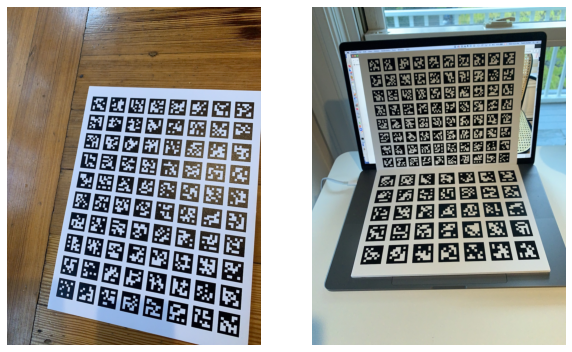

In [ ]:
# The example images include twenty images to demonstrate calibration, and two addtional
# images to demonstrate board detection and relative pose estimation.
# This is how they look:

# fname1= './April/aprilcalibdemo_fine_00001.JPG'
# fname2= './April/aprilcalibdemo_twoboards.JPG'

# plt.figure()
# plt.subplot(121)
# plt.imshow(cv2.cvtColor(cv2.imread(fname1),cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.subplot(122)
# plt.imshow(cv2.cvtColor(cv2.imread(fname2),cv2.COLOR_BGR2RGB))
# plt.axis('off')

### Function: detect_aprilboard()
The next cell defines a function that detects an April board and returns:
* an Nx2 array of the image locations of visble tag centers ((x,y) pixel coordinates)
* an Nx3 array of the corresponding 3D coordinates in the board's coordinate system ((X,Y,Z) in inches)

When both the fine and coarse April boards are visible in the same image, you can call this function twice -- once for each board.

In [ ]:
def detect_aprilboard(img, board, apriltag_detector):
    # Usage:  imgpoints, objpoints, tag_ids = detect_aprilboard(img,board,AT_detector)
    #
    # Input: 
    #   image -- grayscale image
    #   board -- at_coarseboard or at_fineboard (list of dictionaries)
    #   AT_detector -- AprilTag Detector parameters
    #
    # Returns: 
    #   imgpoints -- Nx2 numpy array of (x,y) image coords
    #   objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
    #   tag_ids -- Nx1 list of tag IDs
    
    imgpoints=[]
    objpoints=[]
    tagIDs=[]
    
    # detect april tags
    imgtags = apriltag_detector.detect(img, 
                                    estimate_tag_pose=False, 
                                    camera_params=None, 
                                    tag_size=None)

    if len(imgtags):
        # collect image coordinates of tag centers
        # imgpoints = np.vstack([ sub.center for sub in tags ])

        # list of all tag_id's that are in board
        brdtagIDs = [ sub['tag_id'] for sub in board ]

        # list of all detected tag_id's that are in image
        imgtagIDs = [ sub.tag_id for sub in imgtags ]

        # list of all tag_id's that are in both
        tagIDs = list(set(brdtagIDs).intersection(imgtagIDs))
        
        if len(tagIDs):
            # all board list-elements that contain one of the common tag_ids
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))
            
            # their centers
            objpoints = np.vstack([ sub['center'] for sub in objs ])
    
            # all image list-elements that contain one of the detected tag_ids
            imgs=list(filter(lambda tagnum: tagnum.tag_id in tagIDs, imgtags))    
            
            # their centers
            imgpoints = np.vstack([ sub.center for sub in imgs ])
        
    return imgpoints, objpoints, tagIDs

## Script: Calibrate a Camera 

This cell performs camera calibration, meaning estimation of the intrinsic parameters and radial distortion parameterrs of a camera, using many images of an April board captured from different viewpoints. 

The important output variables are:
* `calMatrix` -- the $3\times 3$ upper-triangular matrix ${\bf K}$
* `distCoeffs` -- an array of distortion coefficients

#### Background and explanation ####

Calibrating a camera means computing its intrinsic parameters, including its calibration matrix ${\bf K}$ and (usually) some lens distortion parameters. A description of the distortion parameters can be found in the openCV documentation for the `cv2.calibrateCamera()` function (go to [this URL](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d) and scroll to the section titled _Detailed Description_.) 

The following cell calibrates a camera using an April board. To properly use this cell, follow these steps:
1. Edit the value of `CALIBFILES` on Line 1 to point to your calibration images. 
2. Edit the value of `BOARD` on Line 5 to indicate whether your images are of the "coarse" or "fine" AprilBoard.
3. Run the cell.

As it runs, the cell prints the number of apriltags detected in each image, and it displays the images and their detections.

Upon completion, the camera calibration information is provided by a pair of variables:
* `calMatrix` -- the $3\times 3$ upper-triangular matrix ${\bf K}$
* `distCoeffs` -- an array of distortion coefficients

Together, this pair of variables provides the ability to compute the pixel coordinates of any 3D point that is in the camera's coordinate system. They also provide the ability to back-project a 2D pixel location to a 3D ray in the camera's coordinate system. 

In general, it's a good idea to save these variables to a file (e.g., using pickle) so that the calibration can be used to process future images that are captured by the same camera.

In addition to this calibration information, the cell produces other variables that are useful for visualization and evaluation of the calibration quality (here, $N$ is the number of calibration images):
* `calImgPoints` -- $N$-element list of numpy arrays. `calImgPoints[i]` is an $M\times 2$ array of $(x,y)$ pixel coordinates for tags detected in the $i$th calibration image. 
* `calObjPoints` -- $N$-element list of numpy arrays. `calObjPoints[i]` is an $M\times 3$ array of $(X,Y,0)$ AprilBoard coordinates (in inches) corresponding to the tags detected in the $i$th calibration image. 
* `calRotations` -- $N$-element list of numpy arrays. `calRotations[i]` is a three-vector representing the 3D rotation, in axis-and-angle format, of the AprilBoard relative to the camera in the $i$th image.
* `calTranslations` -- $N$-element list of numpy arrays. `calRotations[i]` is a three-vector representing the 3D translation of the AprilBoard relative to the camera in the $i$th image.
* `reprojerr` -- the root mean square (RMS) reprojection error in pixels. Indicates the average distance between `calImgPoints` and the corresponding image-projections of `calObjPoints` using the computed calibration (`calMatrix`, `distCoeffs`).

In [ ]:
def calibrateCamera(filepath, board):
  start = time.time()

  # Edit this line to point to the collection of input calibration image
  CALIBFILES = filepath

  # Uncomment one of the following two lines to indicate which AprilBoard is being used (fine or coarse)
  # BOARD = at_fineboard
  BOARD = board

  ###### BEGIN CALIBRATION SCRIPT

  # exit if no images are found or if BOARD is unrecognized
  images = glob.glob(CALIBFILES)
  assert images, "no calibration images matching: " + CALIBFILES
  assert BOARD==at_fineboard or BOARD==at_coarseboard, "Unrecognized AprilBoard"

  # uncomment this line for verbose output
  # print("{} images:".format(len(images)))

  # initialize 3D object points and 2D image points
  calObjPoints = []
  calImgPoints = []

  # set up april tag detector (I use default parameters; seems to be OK)
  at_detector = Detector(families='tag36h11',
                        nthreads=1,
                        quad_decimate=1.0,
                        quad_sigma=0.0,
                        refine_edges=1,
                        decode_sharpening=0.25,
                        debug=0)

  for count,fname in enumerate(images):
      
      # read image and convert to grayscale if necessary
      orig = cv2.imread(fname)
      if len(orig.shape) == 3:
          img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
      else:
          img = orig

      # detect apriltags and report number of detections
      imgpoints, objpoints, tagIDs = detect_aprilboard(img,BOARD,at_detector)
      
      # uncomment this line for verbose output
      #print("{} {}: {} imgpts, {} objpts".format(count, fname, len(imgpoints),len(objpoints)))
      
      # append detections if some are found
      if len(imgpoints) and len(objpoints):
              
          # append points detected in all images, (there is only one image now)
          calObjPoints.append(objpoints.astype('float32'))
          calImgPoints.append(imgpoints.astype('float32'))

  # convert to numpy array
  calObjPoints = np.array(calObjPoints)
  calImgPoints = np.array(calImgPoints)
      
  ## calibrate the camera 
  reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
      calObjPoints, 
      calImgPoints, 
      img.shape,    # image H,W for initialization of the principal point
      None,         # no initial guess for the remaining entries of calMatrix
      None)         # initial guesses for distortion coefficients are all 0

  end = time.time()

  # Print reprojection error. calibrateCamera returns the root mean square (RMS) re-projection error in pixels. 
  # Bad calibration if this value if too big
  print('RMSE of reprojected points:', reprojerr)
  print('Distortion coefficients:', distCoeffs)
  print('Intrinsic camera matrix', calMatrix)
  print('Time use:', end-start)

  return calMatrix, distCoeffs, end-start

## Estimate relative pose

This cell performs camera pose estimation using a pre-calibrated camera and a single image of an April board. 

The equations for accomplishing this tas are introduced at the bottom of the notebook. 

The cell also uses the recovered pose information and `cv2.projectPoints()` to perform some simple "augmented reality" on the detected boards. 

In [ ]:
# Read exist camera intrinsic matrix and calibration distrotion data into variables
calMatrix = pickle.load(open('./data/calMatrix2.pickle', 'rb'))
distCoeffs = pickle.load(open('./data/distCoeffs2.pickle', 'rb'))

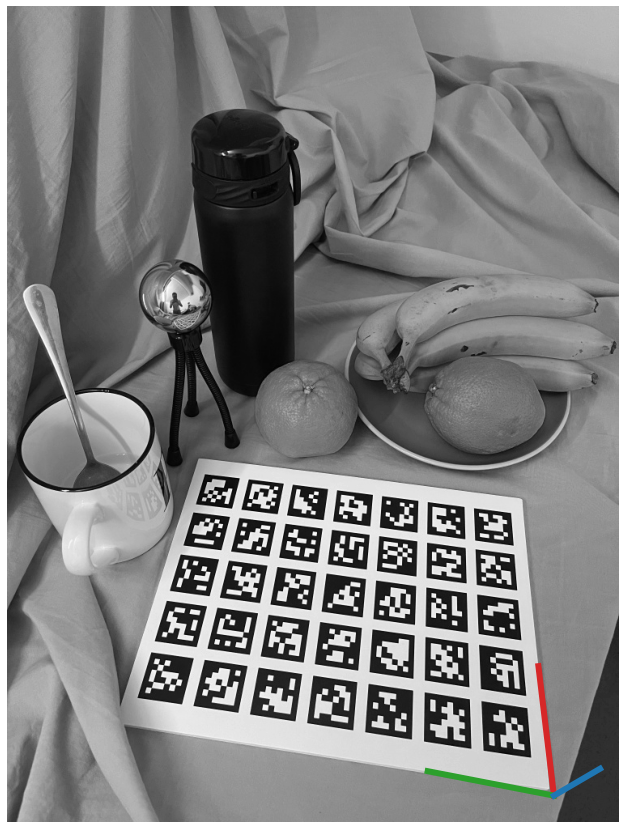

In [ ]:
# image with two AprilBoards (fine and coarse)
fname='./test3/img_compressed_0.jpg'

# read image and convert to grayscale if necessary
orig = cv2.imread(fname)
if len(orig.shape) == 3:
    img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
else:
    img = orig
    
# set up april tag detector (I use default parameters; seems to be OK)
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

# detect apriltags and report number of detections. Do this for both boards (fine and coarse).
# imgpoints_fine, objpoints_fine, tagIDs_fine = detect_aprilboard(img,at_fineboard,at_detector)
imgpoints_coarse, objpoints_coarse, tagIDs_coarse = detect_aprilboard(img,at_coarseboard,at_detector)

# compute normalized image coordinates (equivalent to K^{-1}*x)
# imgpts_fine_norm = cv2.undistortPoints(imgpoints_fine, calMatrix, distCoeffs)
imgpts_coarse_norm = cv2.undistortPoints(imgpoints_coarse, calMatrix, distCoeffs)

# homographies from each board to normalized image pts
# H_fine,_ = cv2.findHomography(objpoints_fine[:,:2],imgpts_fine_norm)
H_coarse,_ = cv2.findHomography(objpoints_coarse[:,:2],imgpts_coarse_norm)

# extract rotation and translation from homography: fineboard
# H_fine = 2*H_fine/(np.linalg.norm(H_fine[:,0]) + np.linalg.norm(H_fine[:,1]))
# R_fine = np.hstack((H_fine[:,:2],np.atleast_2d(np.cross(H_fine[:,0],H_fine[:,1])).T))
# rvec_fine,_ = cv2.Rodrigues(R_fine)
# R_fine,_ = cv2.Rodrigues(rvec_fine)
# tvec_fine=H_fine[:,2]

# extract rotation and translation from homography: coarseboard
H_coarse = 2*H_coarse/(np.linalg.norm(H_coarse[:,0]) + np.linalg.norm(H_coarse[:,1]))
R_coarse = np.hstack((H_coarse[:,:2],np.atleast_2d(np.cross(H_coarse[:,0],H_coarse[:,1])).T))
rvec_coarse,_ = cv2.Rodrigues(R_coarse)
R_coarse,_ = cv2.Rodrigues(rvec_coarse)
tvec_coarse=H_coarse[:,2]

# simple AR: "augment" the image by superimposing XYZ coordinate
#  axes corresponding to each board's coordinate system
fig,ax =  plt.subplots(figsize=(20,15))
plt.imshow(img / 255.0, cmap="gray")
plt.axis('off')

# create four points that define a standard XYZ coordinate-axis object:
#  the origin (0,0,0) and one point three inches along each axis
axes3d = np.float32([[0,0,0], [3,0,0], [0,3,0], [0,0,3]]).reshape(-1,3)

# rotate/translate axes3d object to fineplane origin and project into camera 
# imaxes_fine,_  = cv2.projectPoints(axes3d, rvec_fine, tvec_fine, calMatrix, distCoeffs)

# eliminate the singleton dimension (quirk of openCV format, a bit annoying)
# imaxes_fine = np.squeeze(imaxes_fine) 

# ax.plot(imaxes_fine[[0,1],0], imaxes_fine[[0,1],1], color='#d62728', linewidth=6)
# ax.plot(imaxes_fine[[0,2],0], imaxes_fine[[0,2],1], color='#2ca02c', linewidth=6)
# ax.plot(imaxes_fine[[0,3],0], imaxes_fine[[0,3],1], color='#1f77b4', linewidth=6)

# rotate/translate axes3d object to coarseplane origin and project into camera 
imaxes_coarse,_  = cv2.projectPoints(axes3d, rvec_coarse, tvec_coarse, calMatrix, distCoeffs)

# eliminate the singleton dimension (quirk of openCV format, a bit annoying)
imaxes_coarse=np.squeeze(imaxes_coarse)

ax.plot(imaxes_coarse[[0,1],0], imaxes_coarse[[0,1],1], color='#d62728', linewidth=6)
ax.plot(imaxes_coarse[[0,2],0], imaxes_coarse[[0,2],1], color='#2ca02c', linewidth=6)
ax.plot(imaxes_coarse[[0,3],0], imaxes_coarse[[0,3],1], color='#1f77b4', linewidth=6)

# Project code

## 1. Camera Calibration

### 1.1 Compress test images (do not run the next cell if you have test3 pictures compressed)

In [ ]:
# original images path

CALIBFILES_origin = './test3/IMG*.JPG'

images = glob.glob(CALIBFILES_origin)
scale = 0.25
outname = './test3/img_compressed'

for i, fname in enumerate(images):
  img = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
  width = int(img.shape[1] * scale)
  height = int(img.shape[0] * scale)
  dim = (width, height)
  resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
  cv2.imwrite(f'{outname}_{i}.jpg', resized)

In [ ]:
# compressed images path
CALIBFILES_compress = './test3/img_compressed*.jpg'

# April images path
CALIBFILES_test = './April/aprilcalibdemo_fine_0*.JPG'

# Read original image path
filepath_origin = './test3/IMG_0569.JPG'
img_origin = cv2.imread(filepath_origin, cv2.IMREAD_GRAYSCALE)

# Read original image path
filepath_compress = './test3/img_compressed_0.jpg'
img_compress = cv2.imread(filepath_compress, cv2.IMREAD_GRAYSCALE)

# Read original image path
filepath_test = './April/aprilcalibdemo_fine_00001.JPG'
img_test = cv2.imread(filepath_test, cv2.IMREAD_GRAYSCALE)

### 1.2 Calibrate the original images set

In [ ]:
calMatrix_origin, distCoeffs_origin, time_origin = calibrateCamera(CALIBFILES_origin, at_coarseboard)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



RMSE of reprojected points: 0.8159135931794559
Distortion coefficients: [[ 0.0952919  -0.49153627  0.00813806  0.00283786  0.78740879]]
Intrinsic camera matrix [[3.08172782e+03 0.00000000e+00 1.51963975e+03]
 [0.00000000e+00 3.06635712e+03 2.05346145e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Time use: 60.00168752670288


In [ ]:
with open("./data/calMatrix_origin.pickle", "wb") as f:
    pickle.dump(calMatrix_origin, f)
    f.close()
with open("./data/distCoeffs_origin.pickle", "wb") as f:
    pickle.dump(distCoeffs_origin, f)
    f.close()
with open("./data/time_origin.pickle", "wb") as f:
    pickle.dump(time_origin, f)
    f.close()

### 1.3 Calibrate the compressed images set

In [ ]:
calMatrix_compress, distCoeffs_compress, time_compress = calibrateCamera(CALIBFILES_compress, at_coarseboard)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



RMSE of reprojected points: 0.21406475812346057
Distortion coefficients: [[ 0.0951953  -0.49071844  0.00812664  0.00280714  0.78726787]]
Intrinsic camera matrix [[770.35527292   0.         379.9199512 ]
 [  0.         766.44623854 512.92293302]
 [  0.           0.           1.        ]]
Time use: 14.747148036956787


In [ ]:
with open("./data/calMatrix_compress.pickle", "wb") as f:
    pickle.dump(calMatrix_compress, f)
    f.close()
with open("./data/distCoeffs_compress.pickle", "wb") as f:
    pickle.dump(distCoeffs_compress, f)
    f.close()
with open("./data/time_compress.pickle", "wb") as f:
    pickle.dump(time_compress, f)
    f.close()

### 1.4 Calibrate the April test images

In [ ]:
calMatrix_test, distCoeffs_test, time_test = calibrateCamera(CALIBFILES_test, at_fineboard)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



RMSE of reprojected points: 0.3888051362278334
Distortion coefficients: [[ 1.89626272e-01 -8.90060088e-01  5.15011507e-04 -3.15104650e-04
   1.20005304e+00]]
Intrinsic camera matrix [[1.01481519e+03 0.00000000e+00 5.07157359e+02]
 [0.00000000e+00 1.01442829e+03 6.64991807e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Time use: 22.767408847808838


In [ ]:
with open("./data/calMatrix_test.pickle", "wb") as f:
    pickle.dump(calMatrix_test, f)
    f.close()
with open("./data/distCoeffs_test.pickle", "wb") as f:
    pickle.dump(distCoeffs_test, f)
    f.close()
with open("./data/time_test.pickle", "wb") as f:
    pickle.dump(time_test, f)
    f.close()

### 1.5 Efficiency Comparision

In [ ]:
time_origin = pickle.load(open('./data/time_origin.pickle', 'rb'))
time_compress = pickle.load(open('./data/time_compress.pickle', 'rb'))
time_test = pickle.load(open('./data/time_test.pickle', 'rb'))

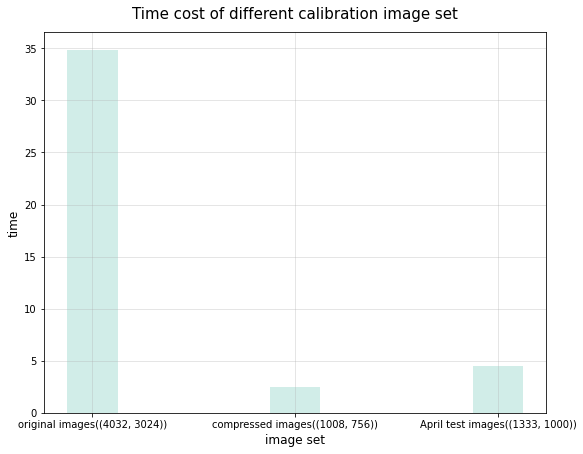

In [ ]:
val = np.array([0, 1, 2])
time_list = [time_origin, time_compress, time_test]
size_list = [img_origin.shape, img_compress.shape, img_test.shape]
fig = plt.figure(figsize=[9, 7])

plt.bar(val, time_list, color='#8dd3c7', alpha=0.4, width=0.25)
plt.xticks(val, [f'original images({size_list[0]})', f'compressed images({size_list[1]})', f'April test images({size_list[2]})'])
plt.xlabel('image set', fontsize=12)
plt.ylabel('time', fontsize=12)
plt.title('Time cost of different calibration image set', y=1.02, fontsize=15)
plt.grid(':', alpha=0.4)
plt.show()

## 2. Camera Calculation

### 2.1 Helper function for compute camera parameters

In [ ]:
# getR(img)
#   the function take in the particular image, and its board type, also the calibration results
#   return R, tvec, rvec
def getR(img_input, board, calMatrix, distCoeffs):

  # read image and convert to grayscale if necessary
  orig = cv2.imread(img_input)
  if len(orig.shape) == 3:
      img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
  else:
      img = orig
      
  # set up april tag detector (I use default parameters; seems to be OK)
  at_detector = Detector(families='tag36h11',
                        nthreads=1,
                        quad_decimate=1.0,
                        quad_sigma=0.0,
                        refine_edges=1,
                        decode_sharpening=0.25,
                        debug=0)

  # detect aprilboard
  imgpts, objpts,_ = detect_aprilboard(img,board,at_detector)

  # compute normalized image coordinates (equivalent to K^{-1}*x)
  imgpts_norm = cv2.undistortPoints(imgpts, calMatrix, distCoeffs)

  # fit homography from board to normalized image pts
  #  (uses openCV's built in version of your own getH() function )
  H,_ = cv2.findHomography(objpts[:,:2],imgpts_norm)

  # scale to make columns 1 and 2 have unit-norm on average
  H = 2*H/(np.linalg.norm(H[:,0]) + np.linalg.norm(H[:,1]))

  # extract rotation and translation
  tvec = H[:,2]
  R = np.hstack((H[:,:2],np.atleast_2d(np.cross(H[:,0],H[:,1])).T))
  rvec,_ = cv2.Rodrigues(R)
  R,_ = cv2.Rodrigues(rvec)

  return R, tvec, rvec

In [ ]:
def getCameraCenter(R, tvec, calMatrix):
  # compute extrinsic matrix using R and t
  extrinsic = np.hstack((R, tvec.reshape(3,1)))

  # compute camera matrix
  P = calMatrix @ extrinsic

  # compute camera center: right null space of camera matrix
  _, _, V = np.linalg.svd(P)
  O = V[-1, :] / V[-1, :][3]
  O = O[:3] # in the plane coordinates

  # in the cam coordinates [0,0,0]
  O = np.concatenate((O, np.ones((1)))).reshape(-1,1)
  O = extrinsic.dot(O).reshape(-1,3)
  
  return O, extrinsic

### 2.2 Camera parameter for original images

In [ ]:
# Read exist camera intrinsic matrix and calibration distrotion data into variables
calMatrix_origin = pickle.load(open('./data/calMatrix_origin.pickle', 'rb'))
distCoeffs_origin = pickle.load(open('./data/distCoeffs_origin.pickle', 'rb'))

# Get camera parameters
R_origin, tvec_origin, rvec_origin = getR(filepath_origin, at_coarseboard, calMatrix_origin, distCoeffs_origin)
camCenter_origin, extrinsic_origin = getCameraCenter(R_origin, tvec_origin, calMatrix_origin)

### 2.3 Camera parameter for compressed images

In [ ]:
# Read exist camera intrinsic matrix and calibration distrotion data into variables
calMatrix_compress = pickle.load(open('./data/calMatrix_compress.pickle', 'rb'))
distCoeffs_compress = pickle.load(open('./data/distCoeffs_compress.pickle', 'rb'))

# Get camera parameters
R_compress, tvec_compress, rvec_compress = getR(filepath_compress, at_coarseboard, calMatrix_compress, distCoeffs_compress)
camCenter_compress, extrinsic_compress = getCameraCenter(R_compress, tvec_compress, calMatrix_compress)

### 2.4 Camera parameter for April images

In [ ]:
# Read exist camera intrinsic matrix and calibration distrotion data into variables
calMatrix_test = pickle.load(open('./data/calMatrix_test.pickle', 'rb'))
distCoeffs_test = pickle.load(open('./data/distCoeffs_test.pickle', 'rb'))

# Get camera parameters
R_test, tvec_test, rvec_test = getR(filepath_test, at_fineboard, calMatrix_test, distCoeffs_test)
camCenter_test, extrinsic_test = getCameraCenter(R_test, tvec_test, calMatrix_test)

## 3. Simple AR, draw a pyramid in test file

In [ ]:
# getProjection()
#   calculate the coordinates by projecting geometry on to image plane
#   plot projected geometry vertex on to image if plot = True
#   return geometry points position on image plane
#   return plot ax if plot = True

def getProjection(geometry_3d, rvec, tvec, calMatrix, distCoeffs, img, plot=False):
  # rotate/translate axes3d object to fineplane origin and project into camera 
  geometry,_ = cv2.projectPoints(geometry_3d, rvec, tvec, calMatrix, distCoeffs)

  # eliminate the singleton dimension (quirk of openCV format, a bit annoying)
  geometry = np.squeeze(geometry)

  if plot:
    fig, ax =  plt.subplots(figsize=(20,15))
    plt.imshow(img / 255.0, cmap="gray")
    plt.axis('off')

    for i in range(len(geometry)):
      ax.plot(geometry[i,0], geometry[i,1],marker='o',color='#ebb434')

  return geometry, ax

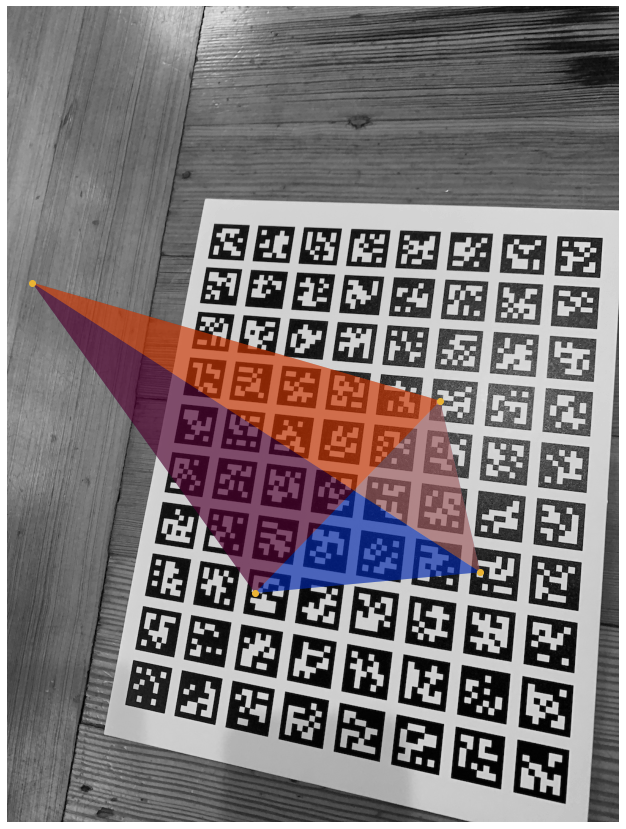

In [ ]:
# Set up pyramid vertex
pyramid_3d = np.float32(
[[3, 4, 0],
 [6, 8, 0],
 [2, 7, 0],
 [4, 6, 10]])

# Calculate the projection of pyramid vertex and plot into image
pyramid, ax = getProjection(pyramid_3d, rvec_test, tvec_test, calMatrix_test, distCoeffs_test, img_test, plot=True)

# draw surface
# Ref: https://stackoverflow.com/questions/26935701/ploting-filled-polygons-in-python
patches = []
polygon_1 = Polygon(np.array([pyramid[0], pyramid[1], pyramid[2]]), True)
patches.append(polygon_1)
polygon_2 = Polygon(np.array([pyramid[3], pyramid[1], pyramid[2]]), True)
patches.append(polygon_2)
polygon_3 = Polygon(np.array([pyramid[3], pyramid[1], pyramid[0]]), True)
patches.append(polygon_3)
polygon_4 = Polygon(np.array([pyramid[3], pyramid[0], pyramid[2]]), True)
patches.append(polygon_4)

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

colors = 100*np.random.rand(len(patches))
p.set_array(np.array(colors))

ax.add_collection(p)
plt.show()

## 4. Compute back projection vector of current points in image

In [ ]:
# backProjection(img, calMatrix, distCoeffs)
#   this function takes in the image and its correspondance calMatrix and distCoeffs
#   return the back projection vectors matrix in cam coordinates

def backProjection(img, calMatrix, distCoeffs):
  # compute img points coordinates (cv2 takes 2*N/N*2 1 channel grid)
  img_width, img_height = img.shape[1], img.shape[0]
  X, Y = np.meshgrid(np.linspace(0, img_width-1, img_width), np.linspace(0, img_height-1, img_height))

  # implement backprojection: two-vectors representing the inhomogeneous coordinates  (x¯1/x¯3,x¯1/x¯3)
  imgpts = np.stack([X.flatten(), Y.flatten()])
  imgpts_norm = cv2.undistortPoints(imgpts, calMatrix, distCoeffs)      # this is inhomogeneous

  # in the cam coordinates
  imgpts_norm_homo = np.concatenate([imgpts_norm[:, :, 0, np.newaxis], imgpts_norm[:, :, 1, np.newaxis], np.ones((imgpts_norm.shape[0], imgpts_norm.shape[1], 1))], axis=2)      # this is homogeneous
  
  return imgpts_norm_homo

### 4.1 Back project original images

In [ ]:
# original images back projection vectors
norm_origin = backProjection(img_origin, calMatrix_origin, distCoeffs_origin)

### 4.2 Back project compressed images

In [ ]:
# original images back projection vectors
norm_compress = backProjection(img_compress, calMatrix_compress, distCoeffs_compress)

### 4.3 Back project test images

In [ ]:
# original images back projection vectors
norm_test = backProjection(img_test, calMatrix_test, distCoeffs_test)

## 5. Image Augmentation

### 5.1 Define spheres

In [ ]:
# sphere 1
# sphere origin within the board coordinates
x1, y1, z1 = 10, 10, 10
C1 = np.float32([x1,y1,z1])

# sphere equation in homogeneous
radius1 = 1.5

In [ ]:
# sphere 2
# sphere origin within the board coordinates
x2, y2, z2 = 3, 3, 0
C2 = np.float32([x2,y2,z2])
# sphere equation in homogeneous
radius2 = 4

In [ ]:
# getCamC:
#   convert 3d coordinate C to camera coordinate C
def getCamC(C, extrinsic):
  # convert into the cam coordinates
  C_cam = np.concatenate((C, np.ones((1)))).reshape(-1,1)
  C_cam = extrinsic.dot(C_cam).reshape(-1,3) 

  return C_cam

### 5.2 BackProjection-Geometry Intersection Calculation

In [ ]:
# solveQuadratic(), intersect() credit to https://www.scratchapixel.com/lessons/3d-basic-rendering/minimal-ray-tracer-rendering-simple-shapes/ray-sphere-intersection provided by Prof. Zickler
def solveQuadratic(a, b, c):
    discr = b * b - 4 * a * c
    if discr < 0:
      return False, False
    elif discr == 0: 
      x0 = - 0.5 * b / a
      x1 = - 0.5 * b / a
    else:
        if b > 0:
            q = -0.5 * (b + math.sqrt(discr))
        else:
            q = -0.5 * (b - math.sqrt(discr))
        x0 = q / a 
        x1 = c / q
    if x0 > x1:
      x0, x1 = x1, x0
    return x0, x1

def intersect(dir, O, radius, C_cam):
    # normalize dir
    dir = dir / np.sqrt(np.sum(dir**2))

    L = O - C_cam
    a = dir.dot(dir.T)
    b = 2 * dir.dot(L.T)
    c = L.dot(L.T) - radius ** 2
    t0, t1 = solveQuadratic(a, b, c)

    if not t0:
      return False
    if t0 > t1:
      t0, t1 = t1, t0
    if t0 < 0:
      t0 = t1
      if t0 < 0:
        return False
    t = t0
    return t

### 5.3 Bounding Box Slicing

In [ ]:
# boundingBoxTrim(origin, radius, img, backproj_vectors, plot)
#   the function aims to accerate the process of camera backprojection and geometry intersection check
#   by defining the the rough bounding shape of the sphere and slice the original backprojection vectors array 
#   return the sliced backprojection vectors

def boudingBoxTrim(origin, radius, img, backproj_vectors, rvec, tvec, calMatrix, distCoeffs, plot=False):
  x0, y0, z0 = origin[0], origin[1], origin[2]
  img_width, img_height = img.shape[1], img.shape[0]

  # bounding box of a sphere
  bounding_box_3d = np.float32([
  [x0+radius, y0+radius, z0+radius],
  [x0+radius, y0+radius, z0-radius],
  [x0+radius, y0-radius, z0+radius],
  [x0+radius, y0-radius, z0-radius],
  [x0-radius, y0+radius, z0+radius],
  [x0-radius, y0+radius, z0-radius],
  [x0-radius, y0-radius, z0+radius],
  [x0-radius, y0-radius, z0-radius],
  ])

  # rotate/translate axes3d object to fineplane origin and project into camera 
  bounding_box,_  = cv2.projectPoints(bounding_box_3d, rvec, tvec, calMatrix, distCoeffs)

  # eliminate the singleton dimension (quirk of openCV format, a bit annoying)
  bounding_box = np.squeeze(bounding_box)
  
  # set up bleeding edge in number of pixels
  bleeding = 1

  # set the trim range by get the bounding square shape of projected bounding box in the picture
  # the bounding square will add another bleeding number for sake of edge points
  x_max, x_min = min(img_width, round(bounding_box[:, 0].max()) + bleeding), max(0, round(bounding_box[:, 0].min()) - bleeding)
  y_max, y_min = min(img_height, round(bounding_box[:, 1].max()) + bleeding), max(0, round(bounding_box[:, 1].min()) - bleeding)

  # trim the backprojection_vectors
  trim_backproj_vectors = backproj_vectors.reshape(img_height, img_width, 1, 3)
  trim_backproj_vectors = trim_backproj_vectors[y_min:y_max, x_min:x_max].reshape(-1, 1, 3)
  size = [x_min, x_max, y_min, y_max]

  return trim_backproj_vectors, size

### 5.4 Implement intersection calculation

In [ ]:
# getSphereIntersection(norm, img, C, radius, O, trim=False)
#   the function calculate the intersection of backprojection vectors and sphere
#   if trim = True, then do bounding box trim
#   return the intersection points in 3d coordinate, and the correspondance backprojection vectors
def getSphereIntersection(norm, img, C, radius, O, extrinsic, rvec, tvec, calMatrix, distCoeffs, trim=False):
  # spherer3d is to store the intersected points at the sphere in camera coordinates
  sphere3d = []
  # intersection_dir is to store the intersection vector in camera coordinates
  intersection_dir = []

  # get camera C of sphere
  C_cam = getCamC(C, extrinsic)

  if trim:
    # Trim norm
    norm_dir, bouding_box = boudingBoxTrim(C, radius, img, norm, rvec, tvec, calMatrix, distCoeffs)
  else:
    norm_dir = norm
    bouding_box = None

  # Implement intersection
  for i in range(len(norm_dir)):
    dir = norm_dir[i]
    t = intersect(dir, O, radius, C_cam)
    if t != False:
      P = O + t * dir
      sphere3d.append(P[0])
      intersection_dir.append(dir[0])

  # change into numpy array
  sphere3d = np.array(sphere3d)
  intersection_dir = np.array(intersection_dir)

  return sphere3d, intersection_dir, bouding_box

In [ ]:
# augmentation(img, sphere3d, rvec, tvec, calMatrix, distCoeffs)
#   the function plot the projected sphere into image plane
#   return the image coordinate of sphere projection

def augmentation(img, sphere3d, rvec, tvec, calMatrix, distCoeffs, bounding_box, plotBox=False):
  # plot image
  fig,ax =  plt.subplots(figsize=(20,15))
  plt.imshow(img / 255.0, cmap="gray")
  plt.axis('off')

  # rotate/translate axes3d object to fineplane origin and project into camera 
  sphere,_  = cv2.projectPoints(sphere3d, rvec, tvec, calMatrix, distCoeffs)

  # eliminate the singleton dimension (quirk of openCV format, a bit annoying)
  sphere = np.squeeze(sphere)

  ax.plot(sphere[:, 0], sphere[:, 1], marker='o',color='#d62728')

  if plotBox:
    for i in range(len(bounding_box)):
      if i == 0 or i == 1:
        ax.vlines(bounding_box[i], bounding_box[2], bounding_box[3], color='#ebb434')
      else:
        ax.hlines(bounding_box[i], bounding_box[0], bounding_box[1], color='#ebb434')

  return sphere

In [ ]:
# intersect C1 in compressed image
sphere3d_compress, intersection_dir_compress, bounding_box = getSphereIntersection(norm_compress, img_compress, C1, radius1, camCenter_compress, extrinsic_compress, rvec_compress, tvec_compress, calMatrix_compress, distCoeffs_compress, trim=True)

with open("./data/sphere3d_compress.pickle", "wb") as f:
    pickle.dump(sphere3d_compress, f)
    f.close()
with open("./data/intersection_dir_compress.pickle", "wb") as f:
  pickle.dump(intersection_dir_compress, f)
  f.close()

In [ ]:
from numpy import linalg as LA

sphere3d_compress = pickle.load(open('./data/sphere3d_compress.pickle', 'rb')) # in the cam coordinates

# convert back into plane coordinates
extrinsic_pinv = LA.pinv(extrinsic_compress)

sphere3d_compress = extrinsic_pinv.dot(sphere3d_compress.T)
sphere3d_compress = (sphere3d_compress[:4,:] / sphere3d_compress[3:,:]).T[:,:3]

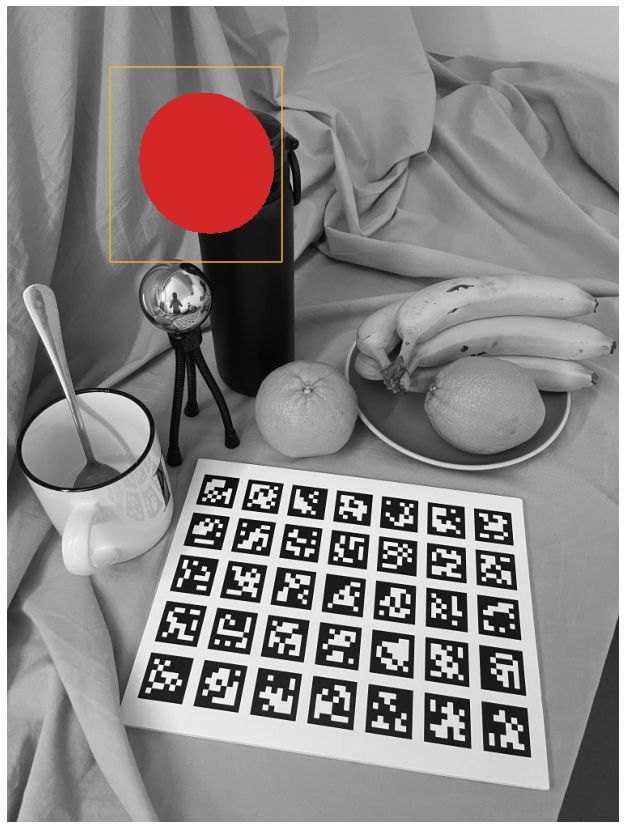

In [ ]:
# plot the sphere
sphere_compress = augmentation(img_compress, sphere3d_compress, rvec_compress, tvec_compress, calMatrix_compress, distCoeffs_compress, bounding_box, plotBox=True)

### 5.5 Bounding Box Efficiency Estimation

In [ ]:
box_time = []

# C1 test
start = time.time()
_,_,_ = getSphereIntersection(norm_compress, img_compress, C1, radius1, camCenter_compress, extrinsic_compress, rvec_compress, tvec_compress, calMatrix_compress, distCoeffs_compress, trim=True)
end = time.time()
box_time.append(end-start)

# C2 test
start = time.time()
_,_,_ = getSphereIntersection(norm_compress, img_compress, C2, radius2, camCenter_compress, extrinsic_compress, rvec_compress, tvec_compress, calMatrix_compress, distCoeffs_compress, trim=True)
end = time.time()
box_time.append(end-start)

In [ ]:
non_box_time = []

# C1 test
start = time.time()
_,_,_ = getSphereIntersection(norm_compress, img_compress, C1, radius1, camCenter_compress, extrinsic_compress, rvec_compress, tvec_compress, calMatrix_compress, distCoeffs_compress, trim=False)
end = time.time()
non_box_time.append(end-start)

# C2 test
start = time.time()
_,_,_ = getSphereIntersection(norm_compress, img_compress, C2, radius2, camCenter_compress, extrinsic_compress, rvec_compress, tvec_compress, calMatrix_compress, distCoeffs_compress, trim=False)
end = time.time()
non_box_time.append(end-start)

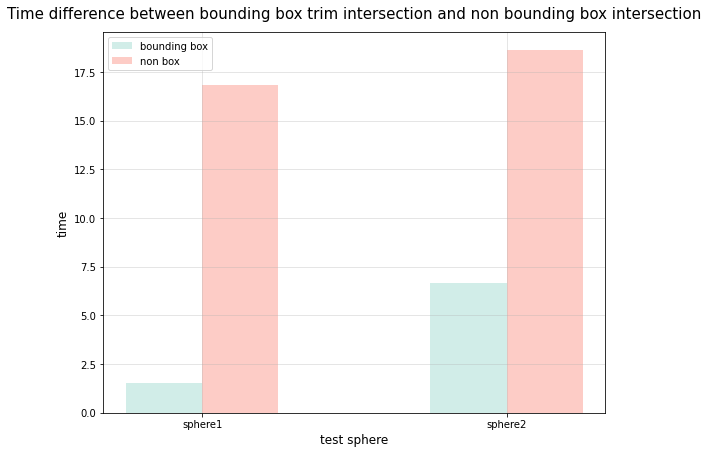

In [ ]:
val = np.array([0, 1])
fig = plt.figure(figsize=[9, 7])

plt.bar(val-0.125, box_time, color='#8dd3c7', alpha=0.4, width=0.25, label='bounding box')
plt.bar(val+0.125, non_box_time, color='#fb8072', alpha=0.4, width=0.25, label='non box')
plt.xticks(val, ['sphere1', 'sphere2'])
plt.xlabel('test sphere', fontsize=12)
plt.ylabel('time', fontsize=12)
plt.legend()
plt.title('Time difference between bounding box trim intersection and non bounding box intersection', y=1.02, fontsize=15)
plt.grid(':', alpha=0.4)
plt.show()

## 6. Lighting Estimation

### 6.1 Simple Light Estimation

In [ ]:
# simpleLight(sphere3d, sphere, C_cam, img)
#   estimate light under assumption that the sphere is lambertian and the light is directional
#   plot the result augmentation image

def simpleLight(sphere3d, sphere, C_cam, img, ambient):
  # compute the norm of intersected points
  n_intersect = sphere3d - C_cam[0]
  n_intersect = n_intersect / np.sqrt(np.square(n_intersect).sum(axis=1)).reshape(-1,1)

  # illumination directions
  s = np.array([-1, 1, 2])

  # calculate light n*l according to BRDF
  light = (n_intersect * s).sum(axis=1)

  # rescale the range to 
  light -= light.min() - ambient
  light /= light.max() + ambient

  sphere = sphere.astype(int)

  img_solid = img.copy()
  for i, l in enumerate(light):
    img_solid[sphere[i,1]][sphere[i,0]] = l * 255

  fig = plt.figure(figsize = [20, 15])
  plt.axis('off')
  plt.imshow(img_solid, cmap='gray')

  return light

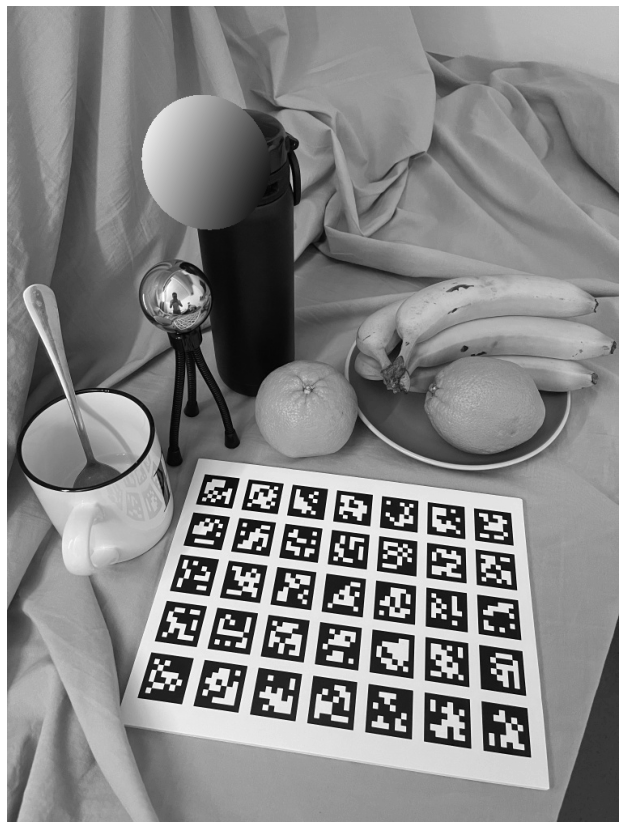

In [ ]:
# plot sphere1 into image
light = simpleLight(sphere3d_compress, sphere_compress, getCamC(C1, extrinsic_compress), img_compress, 0.02)

### 6.2 High Resolution Speculation

In [ ]:
# intersect C2 in compressed image
sphere3d_compress, intersection_dir_compress, bounding_box = getSphereIntersection(norm_compress, img_compress, C2, radius2, camCenter_compress, extrinsic_compress, rvec_compress, tvec_compress, calMatrix_compress, distCoeffs_compress, trim=True)

with open("./data/sphere3d_compress.pickle", "wb") as f:
    pickle.dump(sphere3d_compress, f)
    f.close()
with open("./data/intersection_dir_compress.pickle", "wb") as f:
  pickle.dump(intersection_dir_compress, f)
  f.close()

In [ ]:
from numpy import linalg as LA

sphere3d_compress = pickle.load(open('./data/sphere3d_compress.pickle', 'rb')) # in the cam coordinates

# convert back into plane coordinates
extrinsic_pinv = LA.pinv(extrinsic_compress)

sphere3d_compress = extrinsic_pinv.dot(sphere3d_compress.T)
sphere3d_compress = (sphere3d_compress[:4,:] / sphere3d_compress[3:,:]).T[:,:3]

In [ ]:
# plot the sphere
sphere_compress = augmentation(img_compress, sphere3d_compress, rvec_compress, tvec_compress, calMatrix_compress, distCoeffs_compress, bounding_box, plotBox=True)

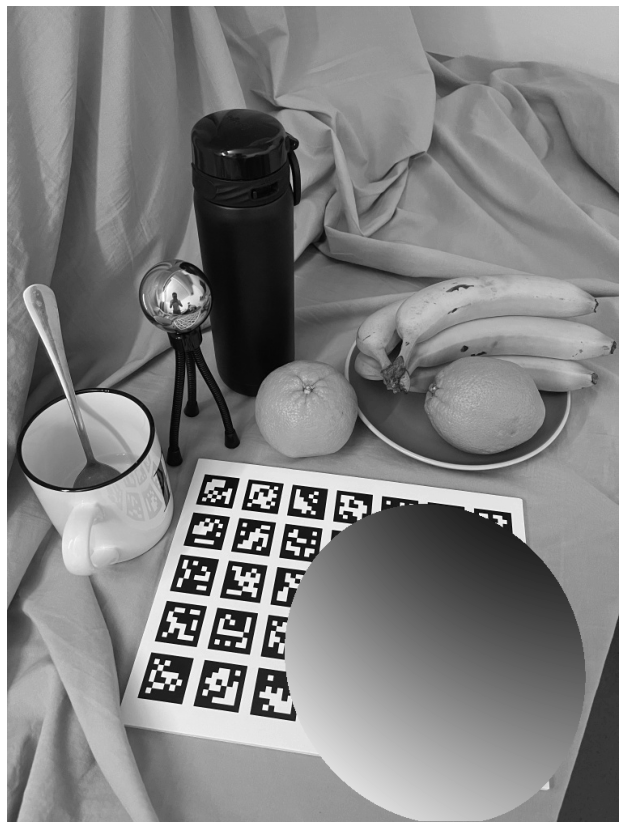

In [ ]:
light2 = simpleLight(sphere3d_compress, sphere_compress, getCamC(C2, extrinsic_compress), img_compress, 0.08)

In [ ]:
# read image as int32 to avoid overflow
img_high_res = cv2.imread('./test3/IMG_0569.JPG', cv2.IMREAD_GRAYSCALE).astype(np.int32)

# calculate the scale factor
sphere_high_res = (sphere_compress * (img_high_res.shape[0] / img_compress.shape[0])).astype(int)

# set reference value into image
for i, l in enumerate(light2):
  img_high_res[sphere_high_res[i,1]][sphere_high_res[i,0]] = l * 255

# speculate the interval values according to reference value
img_high_res_spec = img_high_res.copy()
for i, s in enumerate(sphere_high_res):
  for j in range(4): # y
    for k in range(4): # x
      if j == 0 and k == 0:
        continue
      else:
        img_high_res_spec[s[1]+j][s[0]+k] = img_high_res[s[1]][s[0]] + j/4 * (img_high_res[s[1]+4][s[0]] - img_high_res[s[1]][s[0]]) + k/4 * (img_high_res[s[1]][s[0]+ 4] - img_high_res[s[1]][s[0]])


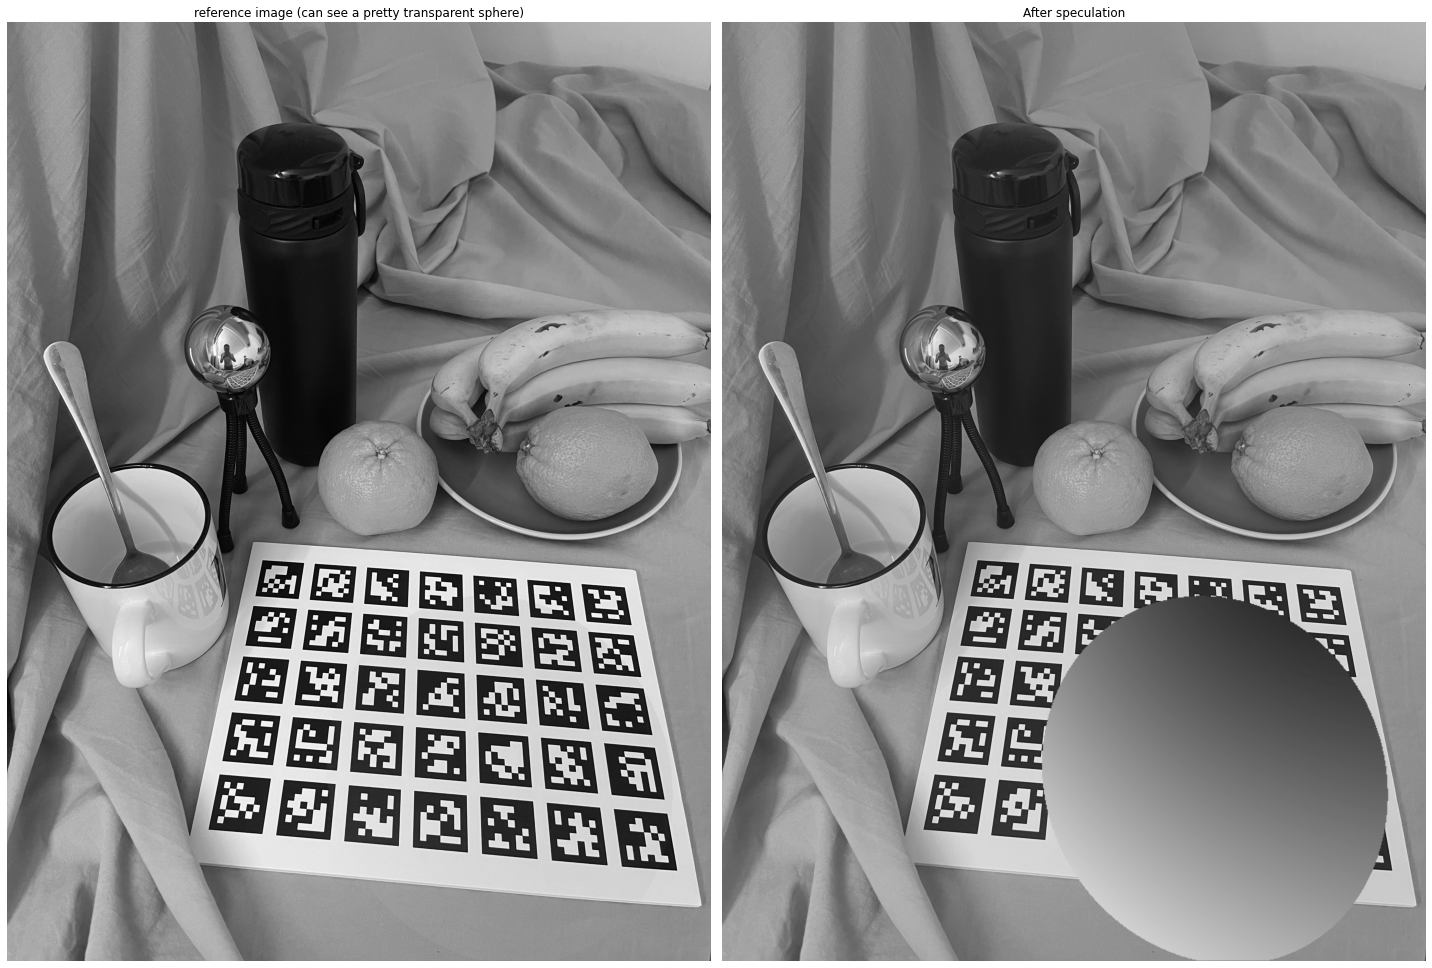

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = [20, 30])
ax1.imshow(img_high_res, cmap='gray')
ax1.axis('off')
ax1.set_title("reference image (can see a pretty transparent sphere)", fontsize=12)
ax2.imshow(img_high_res_spec, cmap='gray')
ax2.axis('off')
ax2.set_title("After speculation", fontsize=12)
plt.tight_layout()
plt.show()

# 7. Multiple Spheres With Overlap

In [ ]:
import math

# sphere origin within the board coordinates
x1, y1, z1 = 10, 10, 10
C1 = np.float32([x1,y1,z1])

# sphere origin within the board coordinates
x2, y2, z2 = 9, 11, 10
C2 = np.float32([x2,y2,z2])

# convert into the cam coordinates
C1 = np.concatenate((C1, np.ones((1)))).reshape(-1,1)
C1 = extrinsic_compress.dot(C1).reshape(-1,3) 
C2 = np.concatenate((C2, np.ones((1)))).reshape(-1,1)
C2 = extrinsic_compress.dot(C2).reshape(-1,3) 

# sphere equation in homogeneous
radius_1 = 1
radius2_1 = radius_1 ** 2
radius_2 = 1
radius2_2 = radius_2 ** 2

# solveQuadratic(), intersect() credit to https://www.scratchapixel.com/lessons/3d-basic-rendering/minimal-ray-tracer-rendering-simple-shapes/ray-sphere-intersection provided by Prof. Zickler
def solveQuadratic(a, b, c):
    discr = b * b - 4 * a * c
    if discr < 0:
      return False, False
    elif discr == 0: 
      x0 = - 0.5 * b / a
      x1 = - 0.5 * b / a
    else:
        if b > 0:
            q = -0.5 * (b + math.sqrt(discr))
        else:
            q = -0.5 * (b - math.sqrt(discr))
        x0 = q / a 
        x1 = c / q
    if x0 > x1:
      x0, x1 = x1, x0
    return x0, x1

def intersect(dir, C, radius2):
    # normalize dir
    dir = dir / np.sqrt(np.sum(dir**2))

    L = camCenter_compress - C
    a = dir.dot(dir.T)
    b = 2 * dir.dot(L.T)
    c = L.dot(L.T) - radius2
    t0, t1 = solveQuadratic(a, b, c)

    if not t0:
      return False
    if t0 > t1:
      t0, t1 = t1, t0
    if t0 < 0:
      t0 = t1
      if t0 < 0:
        return False
    t = t0
    return t

# spherer3d is to store the intersected points at the sphere in camera coordinates
sphere3d_multiple = []
# intersection_dir is to store the intersection vector in camera coordinates
intersection_dir_multiple = []
# sphere center
C_multiple = []
C_current = 1

# Implement intersection
for i in range(len(norm_compress)):
  dir = norm_compress[i]
  t1 = intersect(dir, C1, radius2_1)
  t2 = intersect(dir, C2, radius2_2)

  if (t1 != False) and (t2 != False):
    if t1 <= t2:
      t = t1
      C_current = 1
    else:
      C_current = 2
  elif (t1 == False) and (t2 != False):
    t = t2
    C_current = 2
  elif (t1 != False) and (t2 == False):
    t = t1
    C_current = 1
  else:
    t = False

  if t != False:
    P = camCenter_compress + t * dir
    if sphere3d_multiple == []:
      sphere3d_multiple = P
      intersection_dir_multiple = dir[0]
      if C_current == 1:
        C_multiple = C1
      else:
        C_multiple = C2
    else:
      sphere3d_multiple = np.vstack((sphere3d_multiple, P))
      intersection_dir_multiple = np.vstack((intersection_dir_multiple, dir[0]))
      if C_current == 1:
        C_multiple = np.vstack((C_multiple, C1))
      else:
        C_multiple = np.vstack((C_multiple, C2))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



In [ ]:
# print(sphere3d.shape)
with open("./data/sphere3d_multiple.pickle", "wb") as f:
    pickle.dump(sphere3d_multiple, f)
    f.close()
with open("./data/intersection_dir_multiple.pickle", "wb") as f:
  pickle.dump(intersection_dir_multiple, f)
  f.close()
with open("./data/C_multiple.pickle", "wb") as f:
  pickle.dump(C_multiple, f)
  f.close()

In [ ]:
from numpy import linalg as LA

sphere3d = pickle.load(open('./data/sphere3d_multiple.pickle', 'rb')) # in the cam coordinates

# convert back into plane coordinates
extrinsic_pinv = LA.pinv(extrinsic_compress)

sphere3d_multiple = extrinsic_pinv.dot(sphere3d_multiple.T)
sphere3d_multiple = (sphere3d_multiple[:4,:] / sphere3d_multiple[3:,:]).T[:,:3]

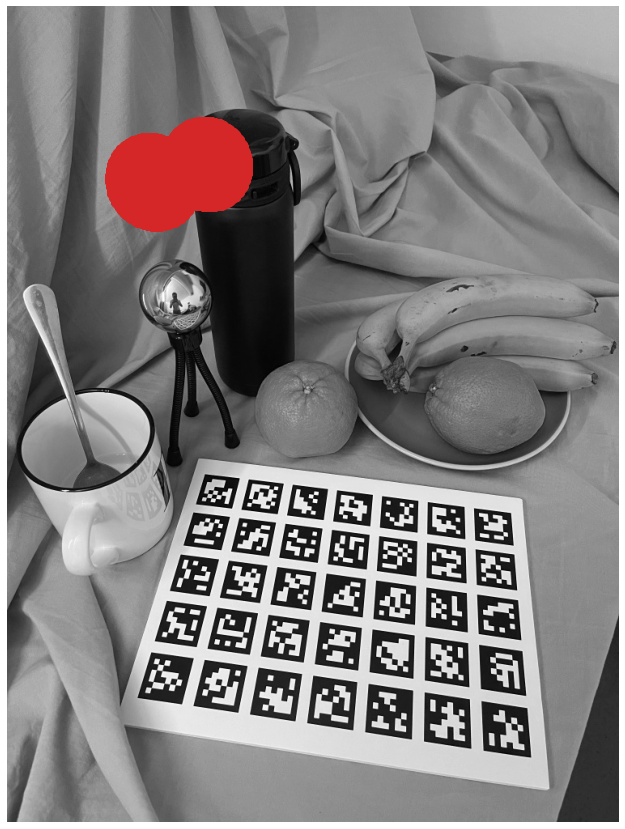

In [ ]:
# image with AprilBoards (fine and coarse)
fname='./test3/img_compressed_0.jpg'

# read image and convert to grayscale if necessary
orig = cv2.imread(fname)
if len(orig.shape) == 3:
    img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
else:
    img = orig

fig,ax =  plt.subplots(figsize=(20,15))
plt.imshow(img / 255.0, cmap="gray")
plt.axis('off')

# rotate/translate axes3d object to fineplane origin and project into camera 
sphere_multiple,_  = cv2.projectPoints(sphere3d_multiple, rvec_compress, tvec_compress, calMatrix_compress, distCoeffs_compress)

# eliminate the singleton dimension (quirk of openCV format, a bit annoying)
sphere_multiple = np.squeeze(sphere_multiple)

for i in range(len(sphere_multiple)):
    ax.plot(sphere_multiple[i,0], sphere_multiple[i,1],marker='o',color='#d62728')

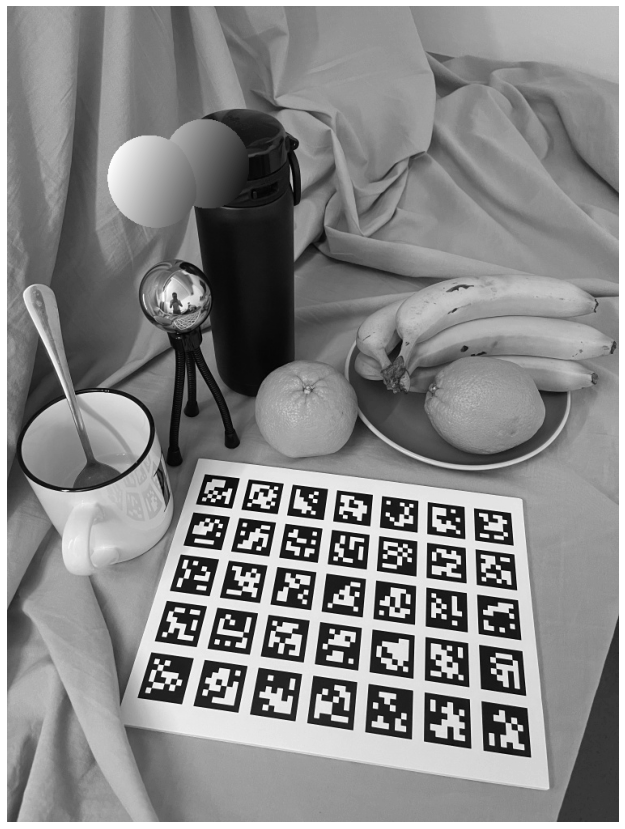

In [ ]:
intersection_dir_multiple = pickle.load(open('./data/intersection_dir_multiple.pickle', 'rb')) # in the cam coordinates
C_multiple = pickle.load(open('./data/C_multiple.pickle', 'rb'))

# compute the norm of intersected points
n_intersect_multiple = sphere3d_multiple - C_multiple
n_intersect_multiple = n_intersect_multiple / np.sqrt(np.square(n_intersect_multiple).sum(axis=1)).reshape(-1,1)

# illumination directions
s = np.array([-1, 1, 2])

# read image
img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

# calculate light
light = (n_intersect_multiple * s).sum(axis=1)

# rescale
ambient = 0.02
light -= light.min() - ambient
light /= light.max()

for i, l in enumerate(light):
  img[round(sphere_multiple[i,1])][round(sphere_multiple[i,0])] = l * 255

fig,ax =  plt.subplots(figsize=(20,15))
plt.axis('off')
plt.imshow(img, cmap='gray')

# 8. This is The End, Thanks!